<a href="https://colab.research.google.com/github/biggiefats/HackerNewsAnalysis/blob/main/HackerNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YCombinator Hacker News Analysis
**Querying the Y Combinator's Hacker News API via GCP and SQL.**

### What is the Y Combinator's Hacker News?
The Hacker News dataset is a collection of data from Y Combinator's Hacker News website (news.ycombinator.com).
The dataset was made in 2016 and was last updated in 2022.
This dataset includes all the posts on the website, comments, threads and overall reception.

### Tools Used
- GCP / Google BigQuery / Google Colab
- SQL
- Python / Jupyter Notebooks
- Data Science / Machine Learning

## Setup

For those of you who want to setup their own EDA with Google BigQuery, run the following code below.

It is assumed you:
- Have a **Google account**
- Have **made a project on GCP**
- Added the **Google BigQuery** datasets to your project
- Know **Python** and **SQL** to a **basic** degree (and Markdown if you want to use Jupyter Notebooks)

In [ ]:
!pip install --upgrade google-cloud-bigquery

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authentication successful.")

Authentication successful.


In [ ]:
# Choosing SQL-Land Project
ID = 'sql-land-443122'

In [ ]:
from google.cloud import bigquery
import pandas as pd

# Establish connection
client = bigquery.Client(project=ID)

## (1) Top 10 Posts, By Comments

Let's find the **top 10** posts, by their comment count.



In [ ]:
query = """
SELECT
  title,
  COUNT(descendants) AS comment_count
FROM
  `bigquery-public-data.hacker_news.full`
GROUP BY
  title
ORDER BY
  comment_count DESC
LIMIT
  10;
"""
query_request = client.query(query=query)

In [ ]:
df = query_request.to_dataframe()
print(df)

                                    title  comment_count
0               Y Combinator: Bookmarklet            644
1                                  Google            208
2     Http://www.addthis.com/bookmark.php            138
3              Mozilla Firefox Start Page            124
4                             Placeholder            106
5                                Facebook             87
6                    Hacker News | Submit             67
7                         How To Download             55
8                                    Test             51
9  HACK your cell phone Get free internet             49


The top 10 titles seem to **variate**.

*Google* and *Facebook* are 2nd and 6th respectively, and they are both top companies for people in tech.

*Test* and *Placeholder* seem to be stories that are just
used to test the function of a story.

The last one seems a bit odd, because it does not follow
the title casing, and has a unreliable title - *HACK your cell phone Get free internet* - I wouldn't trust that!

### (1.1) How Do the Comments Scale Down?

Let's see if there is a **trend** in how the comment count goes **down**, for the top **100** stories.

In [ ]:
# Data visualisation and engineering, if needed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Request
query = """
SELECT
  title,
  COUNT(descendants) AS comment_count
FROM
  `bigquery-public-data.hacker_news.full`
GROUP BY
  title
ORDER BY
  comment_count DESC
LIMIT
  100;
"""
query_request = client.query(query=query)
df = query_request.to_dataframe()

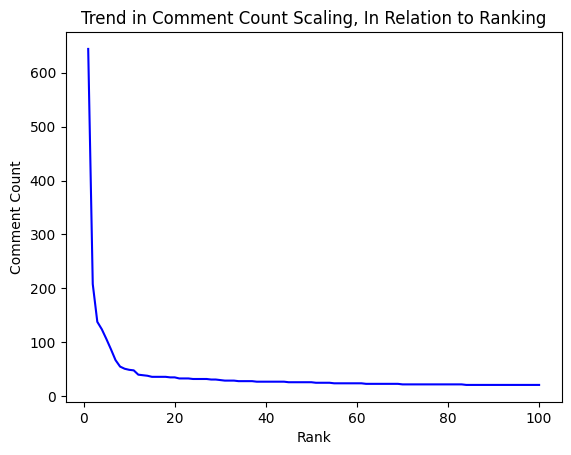

In [ ]:
# Getting data
x = df.index + 1
y = df['comment_count']

# Visualise
fig, ax = plt.subplots()
ax.set_title("Trend in Comment Count Scaling, In Relation to Ranking")
ax.set_xlabel("Rank")
ax.set_ylabel("Comment Count")
ax.plot(x, y, color='blue')
plt.show()

The shape of the graph we have here resembles an **elbow**.
Or, it would resemble the function

$$f(x) \mapsto \frac{1}{x}$$

Surprisingly, we find **Zipf's Law** appear.

---

**Zipf's Law** states that for a **large dataset**, the frequency of the $i$-th most frequent item, denoted as $f(i)$, is
approximately given by:

$$f(i) \sim \frac{C}{i^s}$$
where:
- $f(i)$ is the **frequency** of the $i$-th most frequent item
- $C$ is a constant that **normalizes** the distribution
- $i$ is the **rank** of the item (with 1 being the most frequent)
- $s$ is the **Zipf exponent**, typically close to 1 for many real-world datasets (though it can vary)

Thus, Zipf's Law suggests that the most frequent item occurs roughly twice as often as the second most frequent, three times as often as the third most frequent, and so on. This means the frequency of an event decreases rapidly as the rank increases, following a **power-law distribution**.

---
For our purposes, we assume $s$ to be $1$.

In [ ]:
# Linear Regression helpers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

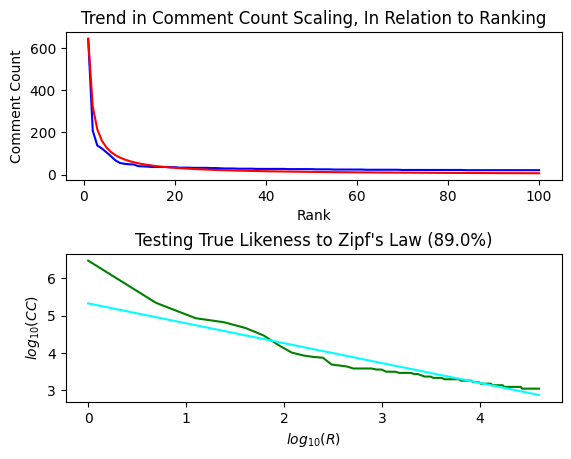

In [ ]:
x = df.index + 1
y = df['comment_count']
# plotting 1/x
x2 = np.arange(1, 101)
y2 = y.values[0] / (x2)
# log both x and y, hoping to get straight line
logx = np.log(x)
logy = np.log(y)
LOGX = logx.values.reshape(-1,1)

# Regression
model = LinearRegression()
model.fit(LOGX, logy)
a = model.intercept_
b = model.coef_
eq = a + b * logx
accuracy = round(model.score(LOGX, logy), 2) * 100

# Visualisation
fig, axes = plt.subplots(nrows=2)
ax = axes[0]
ax.set_title("Trend in Comment Count Scaling, In Relation to Ranking")
ax.set_xlabel("Rank")
ax.set_ylabel("Comment Count")
ax.plot(x, y, color='blue')
ax.plot(x2, y2, color='red')

ax = axes[1]
ax.set_title(f"Testing True Likeness to Zipf's Law ({accuracy}%)")
ax.set_xlabel(r"$log_{10}(R)$")
ax.set_ylabel(r"$log_{10}(CC)$")
ax.plot(logx, logy, color='green')
ax.plot(logx, eq, color='aqua')

plt.subplots_adjust(hspace=0.5)

plt.show()

Yet it may not look like it on the bottom figure, the trend shown by story ranking to comment count fits Zipf's Law quite well, with **89%** accuracy.

## (2) Dead or Alive

Let's see what posts are **dead** in the dataset, and their **average vote count.**

What can be presumed by **dead** is that there is low/no traffic to the post.


In [ ]:
# Request
query = """
SELECT
  COUNT(title) AS number_of_stories,
  ROUND(AVG(score), 1) AS mean_score,
  dead
FROM
  `bigquery-public-data.hacker_news.full`
WHERE
  dead = TRUE
GROUP BY
  dead;
"""
query_request = client.query(query=query)
df = query_request.to_dataframe()
print(df)

   number_of_stories  mean_score  dead
0             849192         1.4  True


**All** the 849,000+ stories are **dead**, which would mean that this dataset is **outdated**, and cannot be compared to today.

The average score for all of these stories is **1.4**, suggesting that a lot of stories did **not** have a good post reach.

## (3) Thriving Times

If we wanted to post something that can go **viral** on YCombinator, we need to know the best time to post.

These times will be in accordance to the **Coordinated Universal Time** (UTC).

In [ ]:
# Request
query = """
SELECT
  EXTRACT(HOUR
  FROM
    timestamp) AS hour,
  ROUND(AVG(score), 1) AS avg_score
FROM
  `bigquery-public-data.hacker_news.full`
WHERE
  title IS NOT NULL
GROUP BY
  hour
ORDER BY
  avg_score DESC
"""
query_request = client.query(query=query)
df = query_request.to_dataframe()
print(df)

    hour  avg_score
0     12       15.0
1     13       14.7
2     16       14.6
3     11       14.6
4     17       14.5
5     15       14.4
6      0       14.4
7     18       14.3
8     23       14.3
9      2       14.3
10     1       14.2
11    14       14.1
12    19       14.1
13     3       13.9
14    22       13.8
15    20       13.7
16    21       13.7
17    10       13.6
18     4       13.4
19     5       13.0
20     9       12.9
21     8       12.7
22     7       12.4
23     6       12.4


We find that, **for those who abide to the UTC time**:
- **Pre and post-afternoon** is the best time to post on average, consider that a post would get $\approx 15$ votes on average from a post
- Posting at **midnight** is **surprisingly effective** - this may be due to the fact that people want to chill at night, and may use HackerNews to soothe themselves
- Posting in the **early morning** is **strongly disliked**, for this would lose $\approx 2$ votes on average - this may not seem like a lot, but successful posts would **not** reach their **max potential** at that time

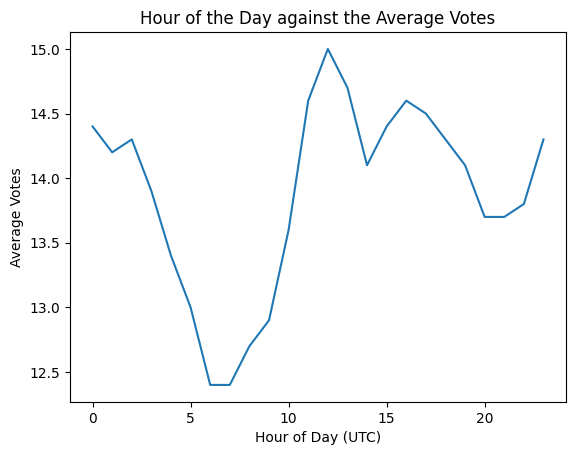

In [ ]:
# Data
df = df.sort_values(by='hour')
x = df['hour'].values
y = df['avg_score'].values

# Visualisation
fig, ax = plt.subplots()
ax.set_title("Hour of the Day against the Average Votes")
ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Votes")
ax.plot(x, y)
plt.show()

### (3.1) Thriving Times - 1000% Luck

Will the graph change if we get the **max** votes instead of the **average** votes?

In [ ]:
# Request
query = """
SELECT
  EXTRACT(HOUR
  FROM
    timestamp) AS hour,
  ROUND(MAX(score)) AS top_score
FROM
  `bigquery-public-data.hacker_news.full`
WHERE
  title IS NOT NULL
GROUP BY
  hour
ORDER BY
  top_score DESC
"""
query_request = client.query(query=query)

    hour  top_score
0      3     6015.0
1      8     5771.0
2     20     5710.0
3     16     4549.0
4      5     4489.0
5     23     4338.0
6     12     4310.0
7     15     4298.0
8     19     4240.0
9     21     4107.0
10    14     4103.0
11    18     3647.0
12     0     3531.0
13    17     3421.0
14     7     3192.0
15    11     3086.0
16    13     3030.0
17    10     3025.0
18    22     2901.0
19     4     2682.0
20     1     2634.0
21     9     2525.0
22     6     2504.0
23     2     2437.0


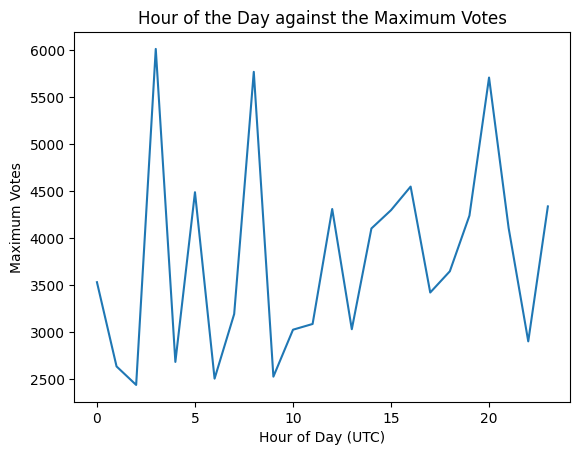

In [ ]:
# Data
df = query_request.to_dataframe()
print(df)
df = df.sort_values(by='hour')
x = df['hour'].values
y = df['top_score'].values

# Visualisation
fig, ax = plt.subplots()
ax.set_title("Hour of the Day against the Maximum Votes")
ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Maximum Votes")
ax.plot(x, y)
plt.show()

We **now** find that, **for those who abide to the UTC time**:
- Posting at **4pm** is the safest time - it averages out a high ranking on both average and max votes
- Someone got very lucky at **8am** 😆; it may have also been that the post reached more people **over time**
- Do not post at **6am** - scored **lowest** on both graphs


## (4) Python VS SQL

Is Python more preferred in 2016 than SQL, in terms of the stats of posts?

In [ ]:
# Request for Python and SQL
for language in ['Python', 'SQL']:
    query = f"""
    SELECT
    ROUND(AVG(score), 2) AS avg_score,
    FROM
    `bigquery-public-data.hacker_news.full`
    WHERE
    title LIKE '%{language}%'
    AND type = 'story';
    """

    query_request = client.query(query=query)
    df = query_request.to_dataframe()

   avg_score
0      17.87
   avg_score
0      20.37


Based on the **stories** posted, we see that posts based on SQL average **3** more votes than Python.

Let's compare this to more languages, and do comparisons.

### (4.1) Language Showdown

Using a LLM to confirm, here are **twenty** popular languages from **2024**. Will these languages have similar popularity in 2016?

Ideally, we should look at the **average, minimum and maximum** score from each language.

Our choice of languages are:
Here's the list in markdown format:

- Python
- JavaScript
- Java
- TypeScript
- C#
- C++
- PHP
- Ruby
- Swift
- Kotlin
- Go
- Rust
- R
- MATLAB
- Dart
- SQL
- Bash
- Scala
- Lua
- Julia


In [ ]:
# Popular Languages
popular_languages = [
    "Python",
    "JavaScript",
    "Java",
    "TypeScript",
    "C#",
    "C++",
    "PHP",
    "Ruby",
    "Swift",
    "Kotlin",
    "Go",
    "Rust",
    "R",
    "MATLAB",
    "Dart",
    "SQL",
    "Bash",
    "Scala",
    "Lua",
    "Julia"
]
df = pd.DataFrame(columns=['language', 'avg_score', 'min_score', 'max_score'])

In [ ]:
for language in popular_languages:
    query = f"""
    SELECT
        '{language}' AS language,
        ROUND(AVG(score), 2) AS avg_score,
        ROUND(MIN(score), 2) AS min_score,
        ROUND(MAX(score), 2) AS max_score
    FROM
        `bigquery-public-data.hacker_news.full`
    WHERE
        title LIKE '%{language}%'
        AND type = 'story';
    """
    query_request = client.query(query=query)
    temp_df = query_request.to_dataframe()
    df = pd.concat([df, temp_df])

In [ ]:
df = df.reset_index()
print(df)

    index    language  avg_score  min_score  max_score
0       0      Python      17.87        0.0     1616.0
1       0  JavaScript      13.85        0.0     1714.0
2       0        Java      12.79        0.0     4103.0
3       0  TypeScript      14.26        1.0     1204.0
4       0          C#      11.18        0.0     1374.0
5       0         C++      17.54        0.0      989.0
6       0         PHP       9.36        0.0      908.0
7       0        Ruby      13.53        0.0      941.0
8       0       Swift      11.72        1.0     1824.0
9       0      Kotlin      10.06        1.0      620.0
10      0          Go      16.23        0.0     4103.0
11      0        Rust      32.42        1.0     1582.0
12      0           R      12.35        0.0     4240.0
13      0      MATLAB       4.46        1.0       24.0
14      0        Dart      10.66        1.0      527.0
15      0         SQL      20.37        0.0     2004.0
16      0        Bash      22.61        1.0      781.0
17      0 

Looking at the data, we can see that it may be **useless** to cover the minimum scores, for they are either $0$ or $1$ and would not show the popularity of a language. So, we should only consider the max and average values.

The scatter plot of the **max score against the average score** may be a good idea.


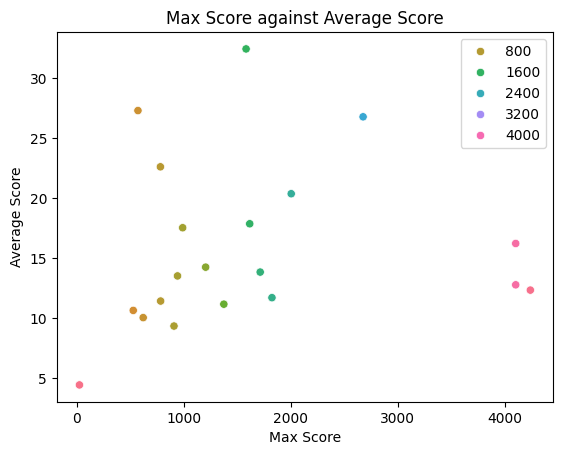

In [ ]:
# Get data
x = df['max_score'].values
y = df['avg_score'].values

# Visualise
fig, ax = plt.subplots()
ax.set_title('Max Score against Average Score')
ax.set_xlabel('Max Score')
ax.set_ylabel('Average Score')
sns.scatterplot(x=x, y=y, hue=x, palette='husl')
plt.show()

From the naked eye, most of the languages follow a **positive proportion** between their **max and average score**.

However, it is hard to tell if that is the **true** pattern.

Instead, we can detect the **outlying** languages, based on the clusters that appear.

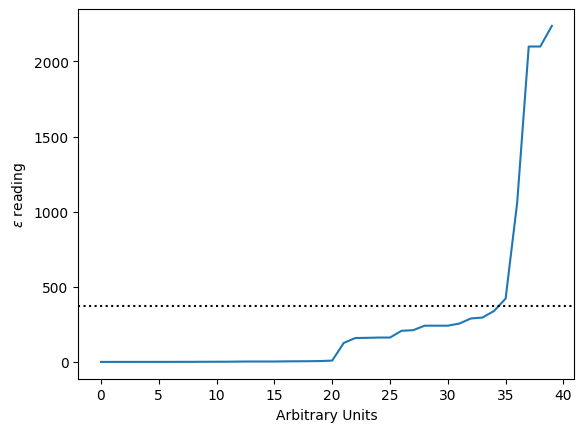

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def dbscan_elbow():
    """
        Finds the elbow of data, for using the DBSCAN algorithm

        The elbow helps us determine the optimum value of epsilon,
        the radius of each circle generated by a core point.
    """
    X = df[['max_score', 'avg_score']].values.reshape(-1, 1)

    model = NearestNeighbors(n_neighbors=4)
    model.fit(X)
    distances, indices = model.kneighbors()
    sorted_distances = np.sort(distances, axis=0)
    max_distances = sorted_distances[:, 3]

    fig, ax = plt.subplots()
    ax.set_xlabel('Arbitrary Units')
    ax.set_ylabel(r'$\epsilon$ reading')
    ax.plot(max_distances)
    ax.axhline(y=370, linestyle='dotted', color='black')
    plt.show() # elbow appears at y_axis

dbscan_elbow()

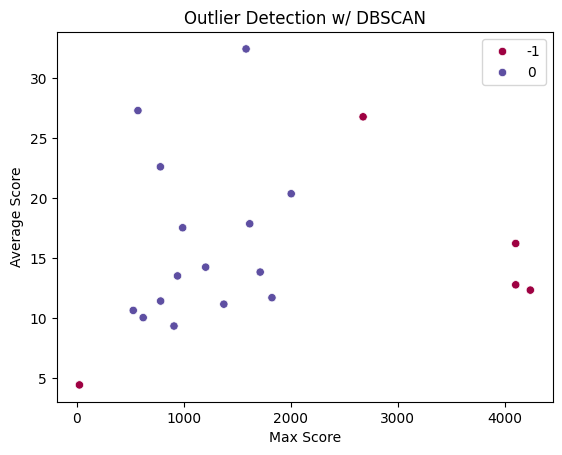

In [ ]:
# min_samples = 2 * N-dim
X = x.reshape(-1,1)
model = DBSCAN(eps=370, min_samples=4)
model.fit(X, y)
labels = model.labels_

# Visualise
fig, ax = plt.subplots()
ax.set_title(f'Outlier Detection w/ DBSCAN')
ax.set_xlabel('Max Score')
ax.set_ylabel('Average Score')
sns.scatterplot(x=x, y=y, hue=labels, palette='Spectral')
plt.show()

We can **now** see that DBSCAN has detected **5** outliers.

In [ ]:
df['labels'] = labels
outliers = df[df['labels'] == -1]
print(outliers)

    index language  avg_score  min_score  max_score  labels
2       0     Java      12.79        0.0     4103.0      -1
10      0       Go      16.23        0.0     4103.0      -1
12      0        R      12.35        0.0     4240.0      -1
13      0   MATLAB       4.46        1.0       24.0      -1
19      0    Julia      26.77        0.0     2676.0      -1


Our outliers are **Java, GO, R, MATLAB, and Julia**.

**MATLAB** is outlying due to its very low average and max score. This may be due to the fact that it is a more preferred option for **engineers**, instead of programmers. **Python** and **R** are more popular options for people working in the data sector.

**Julia** is outlying due to the **high** max score relative to its average score. We can say that Julia follows the formula $m = 100a$, where $m$ is the max score and $a$ is an average score. **Julia** is a numerical/scientific computing language fitted for ML, AI and Scientific Research.

**Java, GO and R** are outlying due to their **very high** max scores. They are all languages that **are useful** but are undermined by languages that do what they do but are more popular.

<ipython-input-121-4d8dba1d8403>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=9)


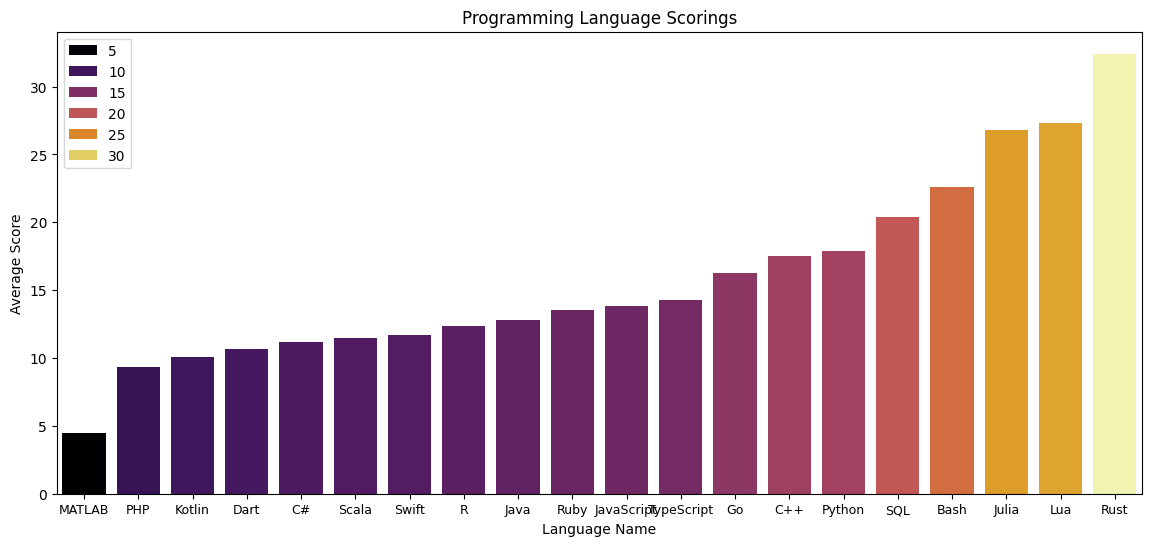

In [ ]:
# Data
df = df.sort_values(by='avg_score')
y = df['avg_score'].values

# Visualisation
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title(f'Programming Language Scorings')
ax.set_xlabel('Language Name')
ax.set_ylabel('Average Score')
sns.barplot(x=df['language'], y=y, hue=y, palette='inferno', width=0.8)
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=9)
plt.show()

## (5) Influencers of HackerNews

For all social media platforms, there are the big names everyone knows of. Whom are the **most popular authors** of YCombinator's HackerNews?

In [73]:
# Querying
query = """
SELECT
  `by` as author, SUM(score) as total_score, SUM(descendants) as total_descendants
FROM
  `bigquery-public-data.hacker_news.full`
WHERE score IS NOT NULL AND descendants IS NOT NULL
GROUP BY
  `by`
ORDER BY
  SUM(score) DESC;
"""

request = client.query(query=query)
df = request.to_dataframe().dropna()

In [ ]:
# Top 10
print(df.head(10))

         author  total_score  total_descendants
0         ingve       453951             203248
1  todsacerdoti       394250             172281
2          tosh       364283             165502
3     pseudolus       335009             242005
4         Tomte       317406             152731
5       rbanffy       292405             138508
6   thunderbong       244504             124001
7           zdw       227501             107165
8           luu       210209             100634
9         danso       204641             123761


Our top 10 posters are listed in the author field.

To find out details about each person, we can make a new dataframe based on their HackerNews profile. We can scrape the profile data using a combination of **Selenium** and **BeautifulSoup**.

In [ ]:
!pip install --upgrade selenium
!apt-get update
!apt-get install chromium-browser

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup

# Webdriver setup
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-gpu')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-javascript')
agent = webdriver.Chrome(options=options)

# Data extraction
info_df = pd.DataFrame(columns=['user', 'created', 'karma', 'about'])

# do top 10, for method is unoptimised and has random runtime (don't know why)
for user in df.head(10)['author'].values:
    agent.get(f'https://news.ycombinator.com/user?id={user}')
    html = agent.page_source
    soup = BeautifulSoup(html, 'lxml')

    stats = soup.find('table', attrs={'border': "0"})
    specific = [t for t in stats.find('tbody').text.split('\n') if t != ''][3].split(":")
    data = [specific[1].replace('created', ''),
            specific[2].replace('karma',''),
            int(specific[3].replace('about', '')),
            specific[4].replace('submissionscommentsfavorites','')]
    info_df.loc[len(info_df)] = data

print(info_df)

           user           created   karma  \
0         ingve    April 12, 2012  201086   
1  todsacerdoti  January 17, 2020  163720   
2          tosh       May 4, 2010  158829   
3     pseudolus  October 22, 2014  163072   
4         Tomte   August 23, 2012  152115   
5       rbanffy    March 12, 2008  162963   
6   thunderbong      May 20, 2012  103007   
7           zdw   August 31, 2010  119987   
8           luu  October 23, 2009  108669   
9         danso     June 14, 2011  163055   

                                               about  
0                                                     
1  Founder/CEO @ Pipedream.com. Also #girldad, in...  
2                                              https  
3                                     Unhappy moron.  
4                                    [ my public key  
5  Seasoned software developer, proficient in Pyt...  
6                                  thunderbong.at.hn  
7  I'm a consultant, sysadmin, and programmer. I ...  
8  danluu

Now that we have our original dataframe sourced from the dataset, and this new dataframe sourced from the web scraped data, we can combine them to find out **more** information about authors.

In [ ]:
df = pd.concat([df, info_df.iloc[:, 1:]], axis=1).dropna()
print(df)

         author  total_score  total_descendants           created     karma  \
0         ingve       453951             203248    April 12, 2012  201086.0   
1  todsacerdoti       394250             172281  January 17, 2020  163720.0   
2          tosh       364283             165502       May 4, 2010  158829.0   
3     pseudolus       335009             242005  October 22, 2014  163072.0   
4         Tomte       317406             152731   August 23, 2012  152115.0   
5       rbanffy       292405             138508    March 12, 2008  162963.0   
6   thunderbong       244504             124001      May 20, 2012  103007.0   
7           zdw       227501             107165   August 31, 2010  119987.0   
8           luu       210209             100634  October 23, 2009  108669.0   
9         danso       204641             123761     June 14, 2011  163055.0   

                                               about  
0                                                     
1  Founder/CEO @ Pip

Most of the author's karma lie in between the **150,000** and **160,000**, with some having smaller amounts.

All of these accounts were created between **2009 - 2012**, with *todsacerdoti* and *pseudolus* being outliers, for they had created their accounts in **2020** and **2014** respectively.

## (5.1) Regression of Descendants, Relative to Score

A good question to ask if there is an implicit relation between the **overall score** a user has, and the **number of descendants** that come from this user's post.

Firstly, let's plot the score and descendants along one another.

TypeError: Cannot interpret 'Int64Dtype()' as a data type

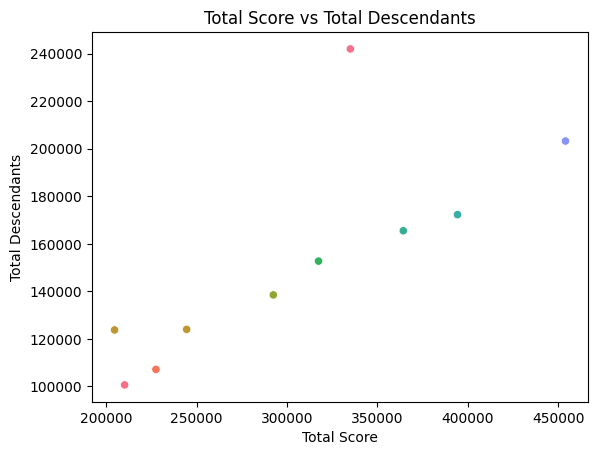

In [ ]:
# Data
x = df['total_score']
y = df['total_descendants']

# Visualisation
fig, ax = plt.subplots()
ax.set_title('Total Score vs Total Descendants')
ax.set_xlabel('Total Score')
ax.set_ylabel('Total Descendants')
sns.scatterplot(x=x, y=y, hue=df['total_descendants'], palette='husl')
plt.show()

Most of the dots form a line of best fit, so this may be best to use a linear regression model to determine the descendant number. However, there will be a **lot of outliers** and the data will be **skewed to the left** if we use more data.

TypeError: Cannot interpret 'Int64Dtype()' as a data type

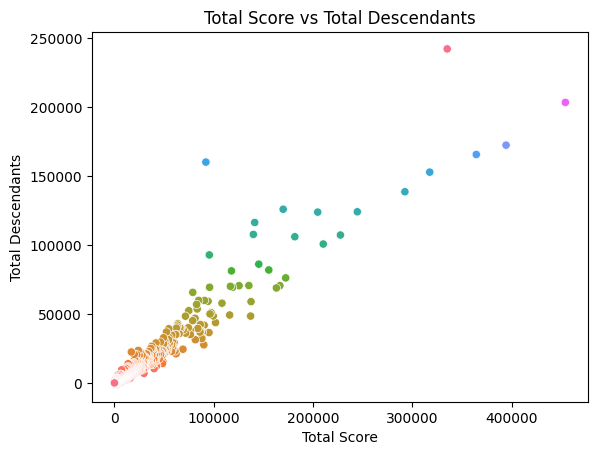

In [ ]:
# Data
x = df['total_score']
y = df['total_descendants']

# Visualisation
fig, ax = plt.subplots()
ax.set_title('Total Score vs Total Descendants')
ax.set_xlabel('Total Score')
ax.set_ylabel('Total Descendants')
sns.scatterplot(x=x, y=y, hue=df['total_descendants'], palette='husl')
plt.show()

As you can see, there is an immense number of **authors** who have low total and descendant scores. This may be due to them **not wanting to post often**, and **lurk** on the HackerNews website to get information.

/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


TypeError: Cannot interpret 'Int64Dtype()' as a data type

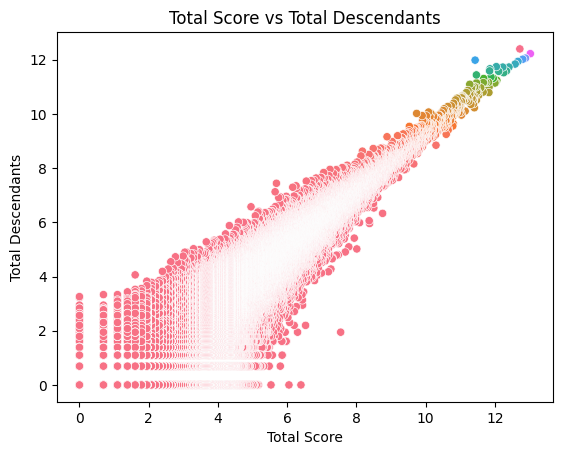

In [ ]:
# Data
x = np.log(df['total_score'])
y = np.log(df['total_descendants'])

# Visualisation
fig, ax = plt.subplots()
ax.set_title('Total Score vs Total Descendants')
ax.set_xlabel('Total Score')
ax.set_ylabel('Total Descendants')
sns.scatterplot(x=x, y=y, hue=df['total_descendants'], palette='husl')
plt.show()

This seems to now fit a shape like a **rocket ship**, with the **authors** that post (a lot) having a low population in the top right. This leads me to believe that we can implement a **Feed-Forward Neural Network** to handle this data, for there is a lot of data.

In [ ]:
!pip install keras

Let's create a **Feedforward Neural Network** to process our **scores**, to turn them into **descendant values**.

For now, we will try with different hyperparameters with a neural network that
has:

- Layer 1: 10 Neurons, Dense, ReLU
- Layer 2: 50% Dropout
- Layer 3: 5 Neurons, Dense, ReLU
- Layer 4: 50% Dropout
- Layer 5: 1 Output
- Optimiser: Adam (high performance)
- Loss Function: Mean Absolute Percentage Error (percentage of error)

---

- 1 epoch, batch size of 32 $\rightarrow$ Loss = $5111.74\%$
- 5 epochs, batch size of 32 $\rightarrow$ Loss = $16351.49\%$
- 10 epochs, batch size of 32 $\rightarrow$ Loss = $9138.35\%$
- 25 epochs, batch size of 32 $\rightarrow$ Loss = $18426.90\%$

As there seems to be no clear change in loss, the architecture of the neural network needs to be changed. Furthermore, it would be bad to have Dropout layers in our **neural network**, as our model has **extremely high variance**.

In [74]:
from sklearn.model_selection import train_test_split
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout

X = df['total_score'].values.reshape(-1,1).astype(np.float32)
y = df['total_descendants'].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=True, random_state=1)

model = Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)

loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}')

Epoch 1/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 96050176.0000
Epoch 2/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 179315.2656
Epoch 3/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 136717.7812
Epoch 4/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 79853.2109
Epoch 5/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 52705.0156
Epoch 6/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 48142.1523
Epoch 7/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 46408.5000
Epoch 8/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 46619.6328
Epoch 9/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 50002.8320
Epoch 10/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 47920.7500
Epoch 11/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 50872.2812
Epoch 12/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 55327.0117
Epoch 13/25
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 51421.3242
Epoch 14/25
2480/2480 ━━━━━━━━━━━━━━━━━━

One key change we should consider is that most authors / users **lurk**; most people don't post content. So, we should **filter** any people that have lower than **2** points and **2** total descendants.

Furthermore, as we established that the **data is skewed to the left**, we need to **scale it logarithmically** to make them data more fairly distributed.

We can also try to **normalise** our data through **a scaler** and the **normalisation** of our batches as we pass them through the network.



In [69]:
from keras.api.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler

df = df[(df['total_score'] > 1) & (df['total_descendants'] > 1)]
X = np.log1p(df['total_score']).values.reshape(-1,1).astype(np.float32)
y = np.log1p(df['total_descendants']).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=True, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(32, activation='linear', input_dim=1))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
model.fit(X_train, y_train, epochs=15, batch_size=32)

loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.2f}%')

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


997/997 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 65.0046
Epoch 2/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 30.6996
Epoch 3/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 28.2122
Epoch 4/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 27.7916
Epoch 5/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 27.3207
Epoch 6/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 27.1192
Epoch 7/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 27.0538
Epoch 8/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 27.1296
Epoch 9/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 26.8744
Epoch 10/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 26.8215
Epoch 11/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 26.7191
Epoch 12/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 26.7341
Epoch 13/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 26.4694
Epoch 14/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 26.9068
Epoch 15/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step -

This now gives us a $24\%$ loss, which is a (minimum) $33,300\%$ improvement from our previous loss percentages.

